In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGY6F3RvnkPGtsg61SsI-7O3NT3M7Qv2ngbbMde3CmaDMG02LP-GeE
Mounted at /content/drive


In [6]:
import pickle
import numpy as np
import pandas as pd

In [7]:
data = pd.read_excel("/content/drive/My Drive/Munna_Research/Experiment/ecdata_new.xlsx", encoding='utf-8')

In [8]:
data = data[['comments', 'quality']]

In [9]:
data.head(3)

,comments,quality
0,Recommended but phone battery cover is not as ...,bad
1,thanks a lot but what is the problem you guys ...,bad
2,মাত্র ১১ দিনে ডেলিভারি পেয়েছি সে জন্য দারাজকে ...,bad


In [10]:
data.quality.unique()

array(['bad', 'bad ', 'good'], dtype=object)

In [11]:
data.quality = data.quality.apply(lambda x: x.strip())

In [12]:
data.quality.value_counts()

good    2830
bad     2279
Name: quality, dtype: int64

## Preprocessing

In [13]:
%%time
import re
data['texts_prep'] = data.comments.apply(lambda x: [i for i in re.sub(r'[^\u0980-\u09E3 A-Za-z]+', ' ', str(x)).split() if len(i) > 1])

CPU times: user 38.7 ms, sys: 2.99 ms, total: 41.7 ms
Wall time: 42.9 ms


In [14]:
data = data[data.texts_prep.apply(lambda x: len(x)) > 0]

In [15]:
data['target'] = data.quality.map({'bad':0, 'good':1})

In [16]:
# !pip install bnlp_toolkit

In [17]:
data.head(3)

,comments,quality,texts_prep,target
0,Recommended but phone battery cover is not as ...,bad,"[Recommended, but, phone, battery, cover, is, ...",0
1,thanks a lot but what is the problem you guys ...,bad,"[thanks, lot, but, what, is, the, problem, you...",0
2,মাত্র ১১ দিনে ডেলিভারি পেয়েছি সে জন্য দারাজকে ...,bad,"[মাত্র, দিনে, ডেলিভারি, পেয়েছি, সে, জন্য, দারা...",0


## Data Partitioning

In [56]:
X = data['texts_prep']
y = data['target']

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=0, stratify=y_val)

print("""Training shape: {}
Validation shape: {}
Testing shape: {}""".format(X_train.shape, X_val.shape, X_test.shape))

Training shape: (4085,)
Validation shape: (715,)
Testing shape: (307,)


## Load fastText pre-trained model

In [20]:
!unzip "/content/drive/My Drive/Munna_Research/Experiment/cc.bn.300.zip" -d /content

Archive:  /content/drive/My Drive/Munna_Research/Experiment/cc.bn.300.zip
  inflating: /content/cc.bn.300.vec  


In [21]:
from gensim.models import KeyedVectors

path = '/content/cc.bn.300.vec'
fastText_model = KeyedVectors.load_word2vec_format(path, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Feature Extraction

In [22]:
def embedding_vectorizer(fastText_model, docs):
    mean_vecs = []
    for instance in docs:
        vecs = []
        for word in instance:
            if word in fastText_model.vocab:
                vecs.append(fastText_model[word])
            else:
                vecs.append(np.zeros(fastText_model.vector_size))
                
        mean_vecs.append(np.mean(vecs, axis=0))
        
    return mean_vecs

In [58]:
x_train_vectorized = embedding_vectorizer(fastText_model, X_train)
x_train_vectorized = pd.DataFrame(x_train_vectorized).add_prefix('col_')

In [59]:
x_val_vectorized = embedding_vectorizer(fastText_model, X_val)
x_val_vectorized = pd.DataFrame(x_val_vectorized).add_prefix('col_')

In [60]:
x_test_vectorized = embedding_vectorizer(fastText_model, X_test)
x_test_vectorized = pd.DataFrame(x_test_vectorized).add_prefix('col_')

## Model

In [61]:
import tensorflow as tf
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

In [65]:
np.random.seed(2)
rn.seed(3)

history = History()

model = Sequential()
model.add(Dense(1024, input_dim=300, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=['accuracy'])

model.fit(np.array(x_train_vectorized), np.array(y_train), 
          validation_data=(np.array(x_val_vectorized), np.array(y_val)), 
          epochs=88, 
          batch_size=2000, 
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Train on 4085 samples, validate on 715 samples
Epoch 1/88
4085/4085 [==============================] - 1s 165us/step - loss: 0.7047 - accuracy: 0.5258 - val_loss: 0.6354 - val_accuracy: 0.6601
Epoch 2/88
4085/4085 [==============================] - 0s 12us/step - loss: 0.6328 - accuracy: 0.6585 - val_loss: 0.5865 - val_accuracy: 0.6979
Epoch 3/88
4085/4085 [==============================] - 0s 11us/step - loss: 0.5828 - accuracy: 0.6974 - val_loss: 0.5365 - val_accuracy: 0.7301
Epoch 4/88
4085/4085 [==============================] - 0s 12us/step - loss: 0.5319 - accuracy: 0.7422 - val_loss: 0.5024 - val_accuracy: 0.7524
Epoch 5/88
4085/4085 [==============================] - 0s 12us/step - loss: 0.5042 - accuracy: 0.7596 - val_loss: 0.5232 - val_accuracy: 0.7413
Epoch 6/88
4085/4085 [==============================] - 0s 11us/step - loss: 0.4943 - accuracy: 0.7682 - val_loss: 0.5029 - val_accuracy: 0.7734
Epoch 7/88
4085/4085 [==============================] - 0s 12us/step - loss: 0.492

In [92]:
# import pickle
# with open("/content/drive/My Drive/Munna_Research/Experiment/model_1.rifat", 'wb') as out_file:
#  pickle.dump(model, out_file)

In [ ]:
# from sklearn.externals import joblib

# # save the model to disk
# filename = "/content/drive/My Drive/Munna_Research/Experiment/model_1.joblib"
# joblib.dump(model, filename)

In [66]:
# for visualization
his_train_acc = history.history['accuracy']
his_val_acc = history.history['val_accuracy']

his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

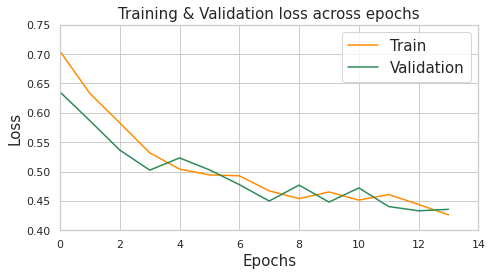

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(7,4))
plt.plot(his_train_loss[:14],'darkorange')
plt.plot(his_val_loss[:14], 'seagreen')

plt.title("Training & Validation loss across epochs",fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.legend(['Train', 'Validation'], fontsize=15 ,loc='upper right')
plt.xlim(0,14)
plt.ylim(0.4, .75)
plt.tight_layout()
plt.savefig("binary_loss_vs_epochs_fastText_munna.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [81]:
loss, test_accuracy = model.evaluate(np.array(x_test_vectorized), np.array(y_test), verbose=0)

In [83]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

accuracy_table = pd.DataFrame([round(train_accuracy, 2), round(val_accuracy, 2), round(test_accuracy, 2)], 
             index=['Training', 'Validation', 'Test'], 
             columns=['Accuracy'])
accuracy_table

,Accuracy
Training,0.84
Validation,0.83
Test,0.84


In [84]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(np.array(x_test_vectorized))
y_pred = [int(round(i)) for i in y_pred.reshape(-1)]
ac = accuracy_score(y_test.tolist(), y_pred)
print(round(ac, 4))

0.8404


In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.tolist(), y_pred)
print(cm)

p = pd.DataFrame(cm, 
                 index=[['Actual','Actual'],['Bad', 'Good']], 
                 columns=[['Predicted','Predicted'],['Bad', 'Good']])

p.style.set_properties(**{'background-color': 'lightgreen', 
                          'color': 'black'})

[[116  21]
 [ 28 142]]


In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [89]:
target_names = ['bad', 'good']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

         bad       0.81      0.85      0.83       137
        good       0.87      0.84      0.85       170

    accuracy                           0.84       307
   macro avg       0.84      0.84      0.84       307
weighted avg       0.84      0.84      0.84       307

